In [99]:
from scipy.signal import convolve2d
from skimage.feature import canny
from commonfunctions import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
from skimage.filters import gaussian, threshold_local
from skimage.transform import hough_line, probabilistic_hough_line
from collections import Counter
from skimage.morphology import binary_closing, binary_opening, binary_erosion, binary_dilation
from skimage.filters import threshold_otsu
from skimage.feature import canny
from skimage import draw
from skimage.transform import resize
from skimage.feature import match_template

In [101]:
def gray_img(img):
    gray = rgb2gray(img)
    if len(img.shape) == 3:
        gray = gray*255
    return gray

In [102]:
def otsu(img):
    blur = gaussian(img)
    otsu_bin = 255*(blur > threshold_otsu(blur))
    return (otsu_bin/255).astype(np.int32)

In [103]:
def rle_encode(arr):
    if len(arr) == 0:
        return [], [], []

    x = np.copy(arr)
    first_dismatch = np.array(x[1:] != x[:-1])
    distmatch_positions = np.append(np.where(first_dismatch), len(x)-1)
    rle = np.diff(np.append(-1, distmatch_positions))
    values = [x[i] for i in np.cumsum(np.append(0, rle))[:-1]]
    return rle, values

In [104]:
def hv_rle(img, axis=1):
    rle, values = [], []

    if axis == 1:
        for i in range(img.shape[1]):
            col_rle, col_values = rle_encode(img[:, i])
            rle.append(col_rle)
            values.append(col_values)
    else:
        for i in range(img.shape[0]):
            row_rle, row_values = rle_encode(img[i])
            rle.append(row_rle)
            values.append(row_values)

    return rle, values

In [105]:
def calculate_pair_sum(arr):
    if len(arr) == 1:
        return list(arr)
    else:
        res = [arr[i] + arr[i + 1] for i in range(0, len(arr) - 1, 2)]
        if len(arr)%2 == 1:
            res.append(arr[-2] + arr[-1])
        return res

In [106]:
def get_most_common(rle):
    pair_sum = [calculate_pair_sum(col) for col in rle]

    flattened = []
    for col in pair_sum:
        flattened += col

    most_common = np.argmax(np.bincount(flattened))
    return most_common

In [121]:
def most_common_bw_pattern(arr, most_common):
    if len(arr) == 1:
        # print("Empty")
        return []
    else:
        res = [(arr[i], arr[i + 1]) for i in range(0, len(arr) - 1, 2) if arr[i] + arr[i + 1] == most_common]

        if len(arr)%2 == 1 and arr[-2] + arr[-1] == most_common:
            res.append((arr[-2], arr[-1]))
        # print(res)
        return res

In [116]:
def calculate_thickness_spacing(rle, most_common):
    bw_patterns = [most_common_bw_pattern(col, most_common) for col in rle]
    bw_patterns = [x for x in bw_patterns if x]  # Filter empty patterns

    flattened = []
    for col in bw_patterns:
        flattened += col

    print(flattened)
    pair, count = Counter(flattened).most_common()[0]

    line_thickness = min(pair)
    line_spacing = max(pair)

    return line_thickness, line_spacing


In [109]:
def rle_decode(starts, lengths, values):
    starts, lengths, values = map(np.asarray, (starts, lengths, values))
    ends = starts + lengths
    n = ends[-1]

    x = np.full(n, np.nan)
    for lo, hi, val in zip(starts, ends, values):
        x[lo:hi] = val
    return x

def hv_decode(rle, values, output_shape, axis=1):
    starts = [[int(np.sum(arr[:i])) for i in range(len(arr))] for arr in rle]

    decoded = np.zeros(output_shape, dtype=np.int32)
    if axis == 1:
        for i in range(decoded.shape[1]):
            decoded[:, i] = rle_decode(starts[i], rle[i], values[i])
    else:
        for i in range(decoded.shape[0]):
            decoded[i] = rle_decode(starts[i], rle[i], values[i])

    return decoded


In [110]:
def remove_black_blocks(rle, values, max_block_height):
    marked_arr = [[rle[i], 'w' if val == 1 else 'b'] for i, val in enumerate(values)]
    for elem in marked_arr:
        if elem[1] == 'b' and elem[0] < max_block_height:
            elem[1] = 'w'

    result, vals = [], []
    next_elem = 0
    for elem in marked_arr:
        if elem[1] == 'w':
            next_elem += elem[0]
        else:
            if next_elem:
                result.append(next_elem)
                vals.append(1)
            result.append(elem[0])
            vals.append(0)
            next_elem = 0
    if next_elem:
        result.append(next_elem)
        vals.append(1)

    return result, vals

def remove_h_lines(img, line_thickness):
    rle, values = hv_rle(img)
    filtered_rle, new_values = [], []
    for i in range(len(rle)):
        res, val = remove_black_blocks(rle[i], values[i], 2 * line_thickness)
        filtered_rle.append(res)
        new_values.append(val)

    return hv_decode(filtered_rle, new_values, img.shape)


def remove_v_lines(img, line_thickness):
    rle, values = hv_rle(img, axis=0)
    filtered_rle, new_values = [], []
    for i in range(len(rle)):
        res, val = remove_black_blocks(rle[i], values[i], 2 * line_thickness)
        filtered_rle.append(res)
        new_values.append(val)

    return hv_decode(filtered_rle, new_values, img.shape, axis=0)


, 2), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (13, 2), (13, 2), (13, 2), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (13, 2), (13, 2), (13, 2), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (13, 2), (13, 2), (13, 2), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (13, 2), (13, 2), (13, 2), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (13, 2), (13, 2), (13, 2), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (13, 2), (13, 2), (13, 2), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (13, 2), (13, 2), (13, 2), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (13, 2), (13, 2), (13, 2), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (12, 3), (13, 2), (13, 2), (13, 2), (12, 3), (12, 3), (12,

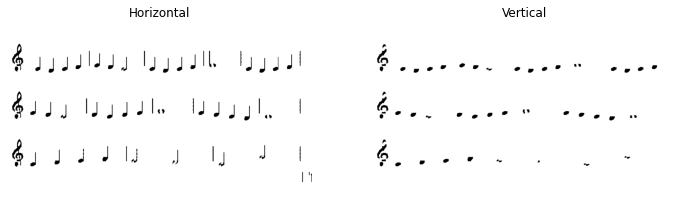

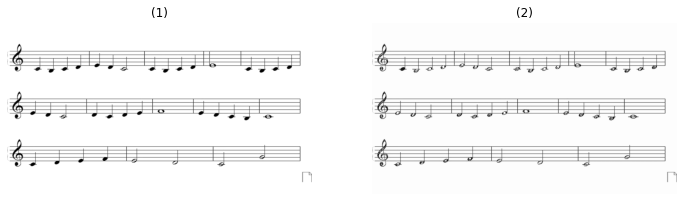

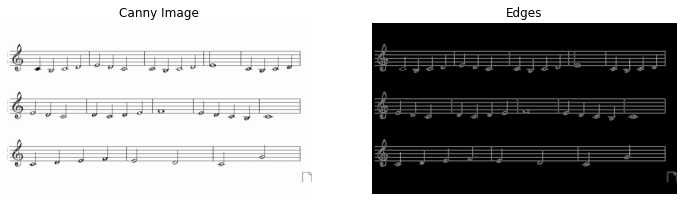

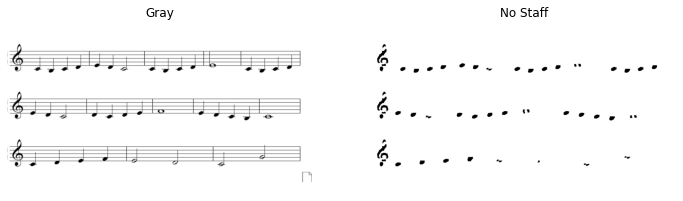

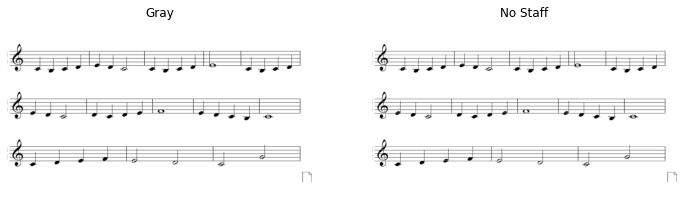

In [122]:
img = io.imread('dataset/mo3eed.jpg')
original = img.copy()
gray = gray_img(img)
bin_img = otsu(gray)
# show_images([gray, bin_img], ['Gray', 'Binary'])

rle, vals = hv_rle(bin_img)
most_common = get_most_common(rle)
# print(rle)
# print(most_common)
thickness, spacing = calculate_thickness_spacing(rle, most_common)

no_h_staff = remove_h_lines(bin_img, thickness)
no_v_staff = remove_v_lines(no_h_staff, thickness)
show_images([no_h_staff, no_v_staff], ['Horizontal', 'Vertical'])
img_without_staff = np.copy(no_v_staff)

canny_img = 255 - 255*(abs(gray-no_h_staff)).astype(np.uint8)
show_images([gray, canny_img])
edges = canny(canny_img, sigma=0.5, low_threshold=50, high_threshold=250)
show_images([canny_img, edges], ['Canny Image', 'Edges'])
# print(lines)
show_images([gray, no_v_staff], ['Gray', 'No Staff'])

no_staff = np.copy(gray)
lines = probabilistic_hough_line(255-gray, threshold=gray.shape[1]//2)
filtered_lines = []
lines = sorted(lines, key=lambda l : l[0][1])
for index, line in enumerate(lines):
    if index > 0 and (line[0][1] - filtered_lines[-1][0][1] < 0.9*spacing):
        pass
    else:
        p1, p2 = line
        x0, y0 = p1
        x1, y1 = p2
        filtered_lines.append(line)
        rr, cc = draw.line(x0, y0, x1, y0)
        # print(rr, cc)
        no_staff[cc, rr] = 255
show_images([gray, no_staff], ['Gray', 'No Staff'])
# inv_bin = 255 - bin_img
# show_images([inv_bin], ['Inverted'])


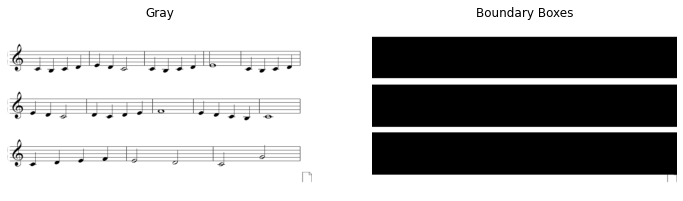

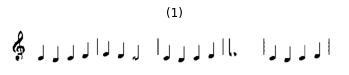

(172, 1280)


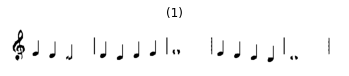

(176, 1280)


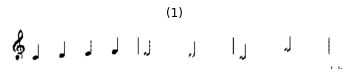

(176, 1280)


In [123]:
top_bottom_lines = []
for index, line in enumerate(filtered_lines):
    if index > 0 and (line[0][1] - top_bottom_lines[-1][1] < 4*spacing):
        pass
    else:
        p1, p2 = line
        x0, y0 = p1
        x1, y1 = p2
        top_bottom_lines.append((x0, y0, x1, y1))

consec_dists = []
for i in range(len(top_bottom_lines)-1):
    consec_dists.append(top_bottom_lines[i+1][1] - top_bottom_lines[i][1])

max_spacing = max(consec_dists)
box_margin = max_spacing//2

centers = []
for i in range(0, len(top_bottom_lines)-1, 2):
    center = (top_bottom_lines[i+1][1] - top_bottom_lines[i][1])//2
    center_y = top_bottom_lines[i][1] + center
    centers.append((center_y, center))

display_margin = max_spacing // 10
roi = []
bboxes = np.copy(gray)
staff_imgs = []
original_staves = []
for index, (center, offset) in enumerate(centers):
    top = int(center) - box_margin - offset + display_margin
    bottom = int(center) + box_margin + offset - display_margin
    roi.append((top, bottom))
    rr, cc = draw.rectangle(start = (top, 0), end = (bottom, bboxes.shape[1]), shape=bboxes.shape)
    staff_img = no_h_staff[top:bottom, 0:bboxes.shape[1]]
    # print(staff_img)
    staff_imgs.append(staff_img)
    original_staves.append(original[top:bottom, 0:bboxes.shape[1]])
    bboxes[rr, cc] = 0
show_images([gray, bboxes], ['Gray', 'Boundary Boxes'])

for staff_img in staff_imgs:
    show_images([staff_img])
    print(staff_img.shape)

152 1816
23


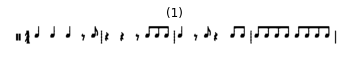

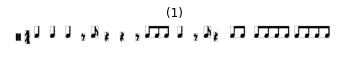

In [89]:
from skimage.morphology import opening, closing, binary_dilation, binary_erosion
from skimage.draw import rectangle_perimeter, rectangle
directions = [(-1,-1),(-1,0),(-1,1),(0,-1),(0,0),(0,1),(1,-1),(1,0),(1,1)]
left = []
right = []
up = []
down = []
img = staff_imgs[0]
# img = binary_erosion(img, np.ones((3, 3)))
if thickness % 2 == 0:
    thickness = thickness + 1
img = binary_erosion(img, np.ones((thickness, thickness)))
# show_images([img])
#img = gaussian(img,sigma=1)
# img = binary(img,128)
print (img.shape[0],img.shape[1])
# img = img[0:70,50:600]
result = np.copy(img)
def mark_component(x,y,numberOfObjects):
    if x == result.shape[0] or y == result.shape[1] or x < 0 or y < 0 or result[x][y] != 0:
        return
    result[x][y] = numberOfObjects + 1
    if y < up[numberOfObjects]:
        up[numberOfObjects] = y
    if y > down[numberOfObjects]:
        down[numberOfObjects] = y
    if x < left[numberOfObjects]:
        left[numberOfObjects] = x
    if x > right[numberOfObjects]:
        right[numberOfObjects] = x
    for i in range(9):
        mark_component(x+directions[i][0],y+directions[i][1],numberOfObjects)
    
def connected_components():
    numberOfObjects = 0
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if (result[x][y] == 0):
                left.append(x)
                up.append(y)
                right.append(x)
                down.append(y)
                mark_component(x,y,numberOfObjects)
                numberOfObjects = numberOfObjects + 1
    return numberOfObjects

no= connected_components()
# print(mostLeft)
print(no)
show_images([img])
for i in range (len(left)):
    if down[i]-up[i] < 10 or right[i]-left[i] < 10:
        rr, cc = rectangle(start = (left[i], up[i]), end = (right[i], down[i]), shape=img.shape)
        rr = np.array(rr,dtype='int')
        cc = np.array(cc,dtype='int')
        img[rr, cc] = 255
    else: 
        rr, cc = rectangle_perimeter(start = (left[i], up[i]), end = (right[i], down[i]), shape=img.shape)
        rr = np.array(rr,dtype='int')
        cc = np.array(cc,dtype='int')
        img[rr, cc] = 0
show_images([img])
# for x in range(result.shape[0]):
#     for y in range(result.shape[1]):
#         if (result[x][y] != 255):
#             print(result[x][y])


In [90]:
clef_lower, clef_upper, clef_thresh = 50, 70, 0.7

clef_imgs = {
    "treble": [io.imread('dataset/treble_1.jpg'), io.imread('dataset/treble_2.jpg')],
    "bass": [io.imread('dataset/bass_1.jpg')]
}

In [91]:
def match(img, templates, start, stop, threshold):
    # height, width = img.shape[::-1]
    best_location_count = -1
    best_locations = []
    best_scale = 1

    x = []
    y = []
    for scale in [i/100.0 for i in range(start, stop+1, 3)]:
        locations = []
        location_count = 0
        for template in templates:
            if scale*template.shape[0] > img.shape[0] or scale*template.shape[1] > img.shape[1]:
                continue

            template = resize(template, (int(scale*template.shape[0]), int(scale*template.shape[1])))
            template = gray_img(template)
            result = match_template(img, template)
            result = np.where(result >= threshold)
            location_count += len(result[0])
            locations += [result]
        x.append(location_count)
        y.append(scale)

        if location_count > best_location_count:
            best_location_count = location_count
            best_locations = locations
            best_scale = scale
        elif location_count < best_location_count:
            pass
    
    return best_locations, best_scale

In [92]:
def find_templates(img, templates, start, stop, threshold):
    locations, scale = match(img, templates, start, stop, threshold)
    img_locations = []
    for i in range(len(templates)):
        # h, w = templates[i].shape
        h = templates[i].shape[0]
        w = templates[i].shape[1]
        # print(templates[i].shape)
        w *= scale
        h *= scale
        img_locations.append([(pt[0], pt[1], w, h) for pt in zip(*locations[i][::-1])])
    
    return img_locations

In [93]:
def calculate_overlap(a, b):
    overlap_x = max(0, min(a[0]+a[2], b[0]+b[2]) - max(a[0], b[0]))
    overlap_y = max(0, min(a[1]+a[3], b[1]+b[3]) - max(a[1], b[1]))
    overlap_area = overlap_x*overlap_y
    area = a[2]*a[3]
    return overlap_area/area

In [94]:
def merge2boxes(a, b):
    x = min(a[0], b[0])
    y = min(a[1], b[1])
    w = max(a[0]+a[2], b[0]+b[2]) - x
    h = max(a[1]+a[3], b[1]+b[3]) - y
    return (x, y, w, h)

In [95]:
def merge_boxes(boxes, threshold):
    filtered_boxes = []
    while len(boxes) > 0:
        r = boxes.pop(0)
        boxes.sort(key=lambda box: np.sqrt( ((box[0]+box[2]/2) - (r[0]+r[2]/2))**2 + ((box[1]+box[3]/2) - (r[1]+r[3]/2))**2))
        merged = True
        while merged:
            merged = False
            i = 0
            for _ in range(len(boxes)):
                if calculate_overlap(r, boxes[i]) > threshold or calculate_overlap(boxes[i], r) > threshold:
                    r = merge2boxes(r, boxes.pop(i))
                    merged = True
                elif np.sqrt(((boxes[i][0]+boxes[i][2]/2) - (r[0]+r[2]/2))**2+((boxes[i][1]+boxes[i][3]/2) - (r[1]+r[3]/2))**2) > r[2]/2 + boxes[i][2]/2:
                    break
                else:
                    i += 1
        filtered_boxes.append(r)
    return filtered_boxes

In [96]:
staff_clefs = [-1]*len(staff_imgs)
for i in range(len(staff_imgs)):
    for clef in clef_imgs:
        print("Matching clef images")
        clef_boxs = find_templates(staff_imgs[i], clef_imgs[clef], clef_lower, clef_upper, clef_thresh)
        clef_boxs = merge_boxes([j for i in clef_boxs for j in i], 0.5)

        if len(clef_boxs) == 1:
            print('Clef Found, الحمدلله', clef)
            staff_clefs[i] = clef

            clef_boxes_img = staff_imgs[i].copy()

            for boxes in clef_boxs:
                rr, cc = draw.rectangle_perimeter(start = (boxes[1], boxes[0]), end = (boxes[1]+boxes[3], boxes[0]+boxes[2]), shape=clef_boxes_img.shape)
                rr = np.array(rr,dtype='int')
                cc = np.array(cc,dtype='int')
                original_staves[i][rr, cc, 0] = 255
                original_staves[i][rr, cc, 1] = 0
                original_staves[i][rr, cc, 2] = 0
                io.imsave(f"clef{i+1}.png", original_staves[i])
                show_images([original_staves[i]])
            
            break
        else:
            print("No clef", i+1)

Matching clef images
No clef 1
Matching clef images
No clef 1
Matching clef images
No clef 2
Matching clef images
No clef 2


In [97]:
time_imgs = {
    "common": [io.imread(time) for time in ["dataset/common.jpg"]],
    "44": [io.imread(time) for time in ["dataset/44.png"]],
    "34": [io.imread(time) for time in ["dataset/34.jpg"]],
    "24": [io.imread(time) for time in ["dataset/24.jpg"]],
    "68": [io.imread(time) for time in ["dataset/68.jpg"]]
}
time_lower, time_upper, time_thresh = 50, 100, 0.7

In [98]:
staff_time = [-1]*len(staff_imgs)
for i in range(len(staff_imgs)):
    for time in time_imgs:
        print("Matching time images")
        time_boxes = find_templates(staff_imgs[i], time_imgs[time], time_lower, time_upper, time_thresh)
        time_boxes = merge_boxes([j for i in time_boxes for j in i], 0.5)

        if len(time_boxes) == 1:
            print('Time Found, الحمدلله', clef)
            staff_time[i] = time

            time_boxes_img = staff_imgs[i].copy()

            for boxes in time_boxes:
                rr, cc = draw.rectangle_perimeter(start = (boxes[1], boxes[0]), end = (boxes[1]+boxes[3], boxes[0]+boxes[2]), shape=time_boxes_img.shape)
                rr = np.array(rr,dtype='int')
                cc = np.array(cc,dtype='int')
                original_staves[i][rr, cc, 0] = 255
                original_staves[i][rr, cc, 1] = 0
                original_staves[i][rr, cc, 2] = 0
                io.imsave(f"time{i+1}.png", original_staves[i])
                show_images([original_staves[i]])
            
            break
        elif len(time_boxes) == 0 and i > 0:
            staff_time.append(staff_time[i-1])
            print("Same as previous", i+1)
        else:
            print("No time", i+1)

Matching time images
No time 1
Matching time images
No time 1
Matching time images
No time 1
Matching time images
No time 1
Matching time images
No time 1
Matching time images
Same as previous 2
Matching time images
Same as previous 2
Matching time images
Same as previous 2
Matching time images
Same as previous 2
Matching time images
Same as previous 2
